<a href="https://colab.research.google.com/github/SebasG22/xplat/blob/master/Improved_Coffee_Consumption_Chatbot_Script_(Cloudflare_Workers_AI_Batch_API).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DataFrame loaded successfully:
                            Country      Coffee type    1990/91    1991/92  \
0                            Angola  Robusta/Arabica    1200000    1800000   
1  Bolivia (Plurinational State of)          Arabica    1500000    1620000   
2                            Brazil  Arabica/Robusta  492000000  510000000   
3                           Burundi  Arabica/Robusta     120000      96000   
4                           Ecuador  Arabica/Robusta   21000000   21000000   

     1992/93    1993/94    1994/95    1995/96    1996/97    1997/98  ...  \
0    2100000    1200000    1500000     600000    1200000    2400000  ...   
1    1650000    1710000    1770000    1830000    1890000    1950000  ...   
2  534000000  546000000  558000000  606000000  660000000  690000000  ...   
3     102000     114600     120000     120000     120000     120000  ...   
4   21000000   21000000   21000000   21000000   18000000   18000000  ...   

      2011/12     2012/13     2013/14     2

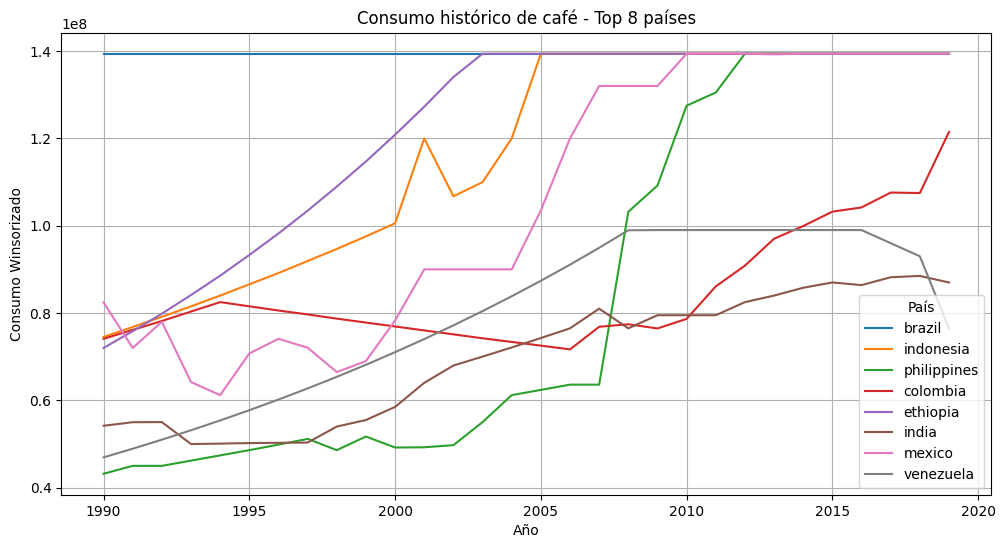

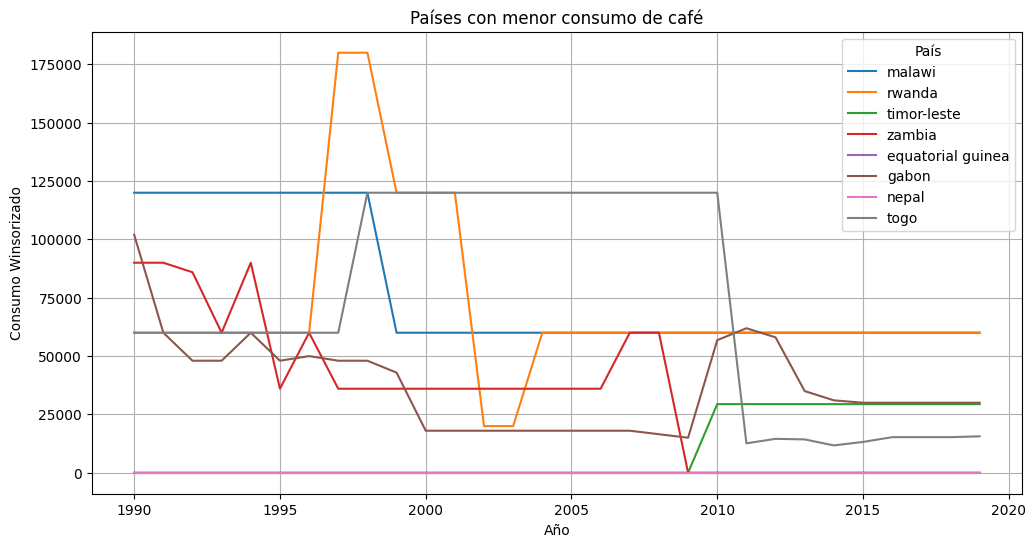

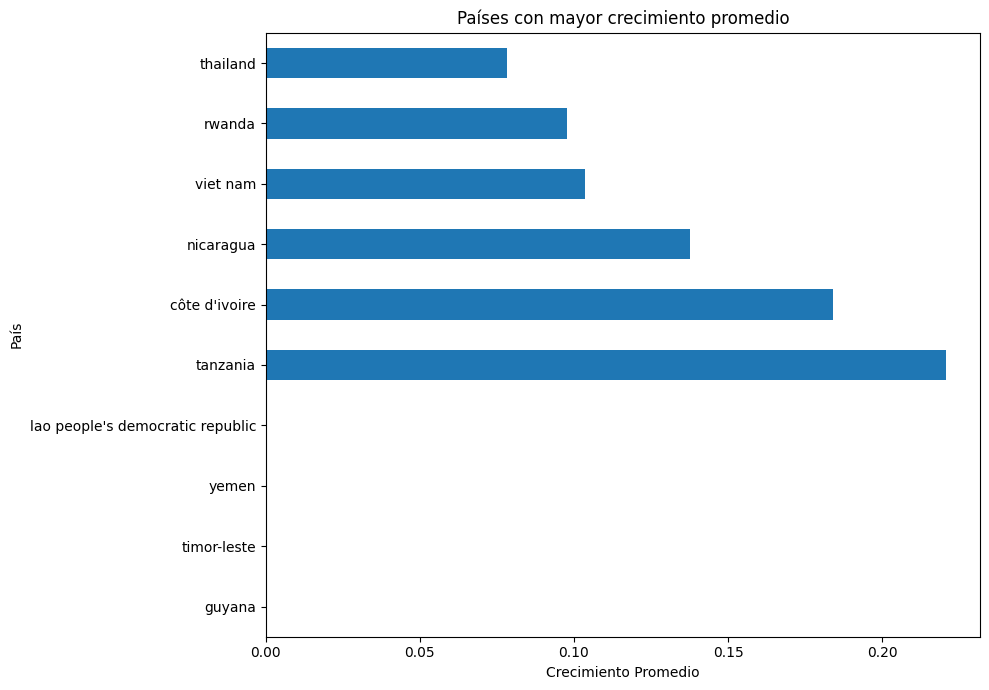

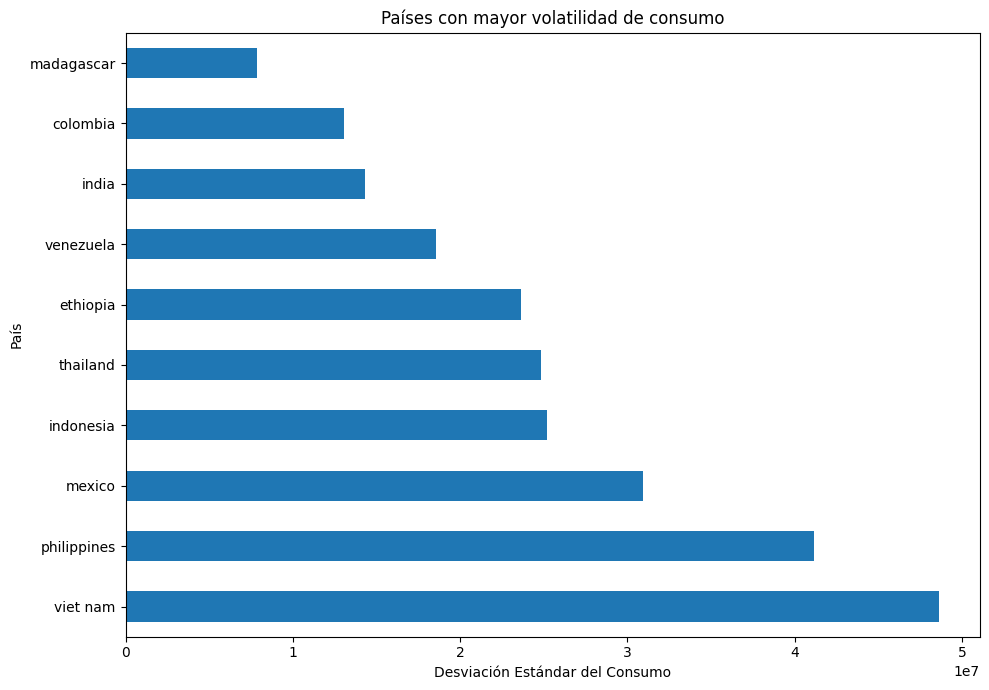

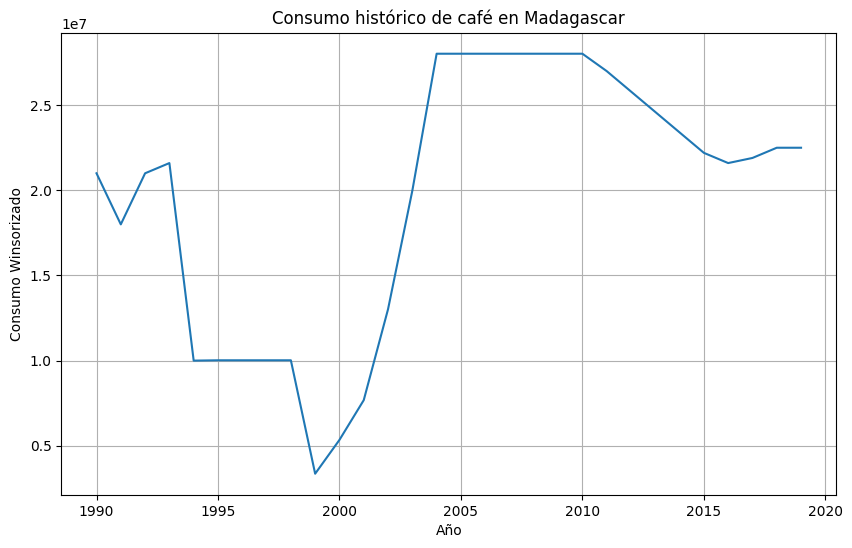

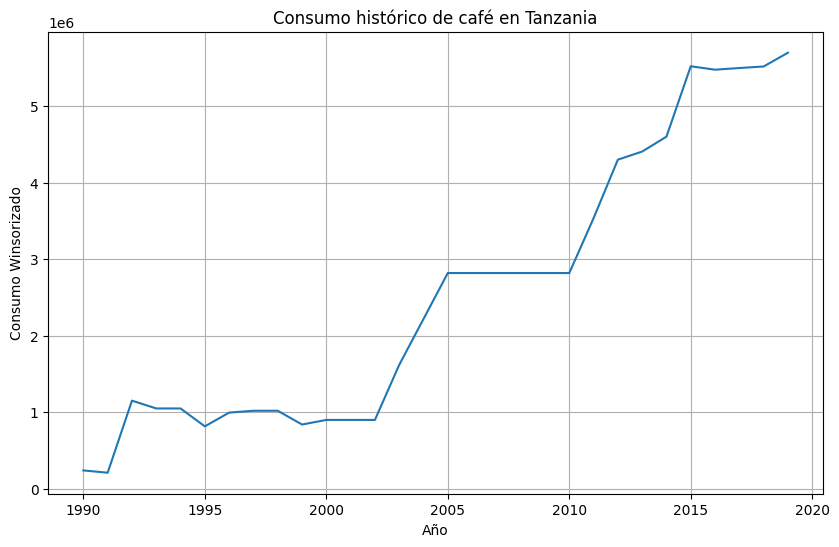

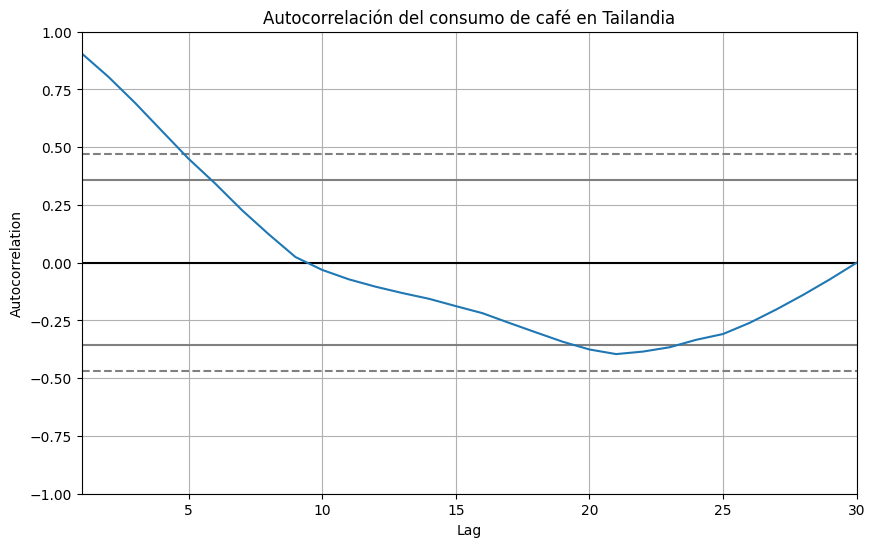

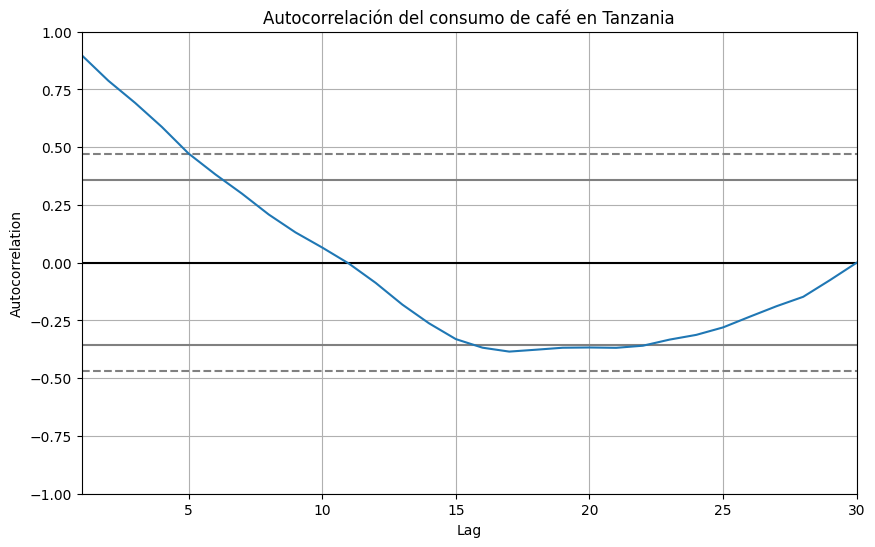

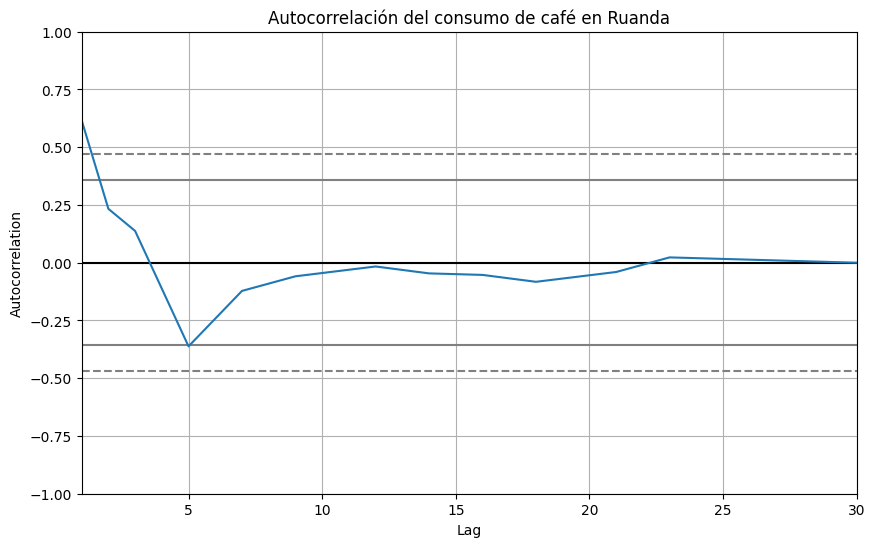


--- df_long head (after all processing) ---
                            Country      Coffee_type  \
0                            angola  robusta/arabica   
1  bolivia (plurinational state of)          arabica   
2                            brazil  arabica/robusta   
3                           burundi  arabica/robusta   
4                           ecuador  arabica/robusta   

   Total_domestic_consumption  consumption  start_year  end_year  \
0                    46500000      1200000        1990      1991   
1                    75180000      1500000        1990      1991   
2                 27824700000    492000000        1990      1991   
3                     3412020       120000        1990      1991   
4                   381540000     21000000        1990      1991   

   consumption_winsorized  growth  
0                 1200000     NaN  
1                 1500000     NaN  
2               139392000     NaN  
3                  120000     NaN  
4                21000000    

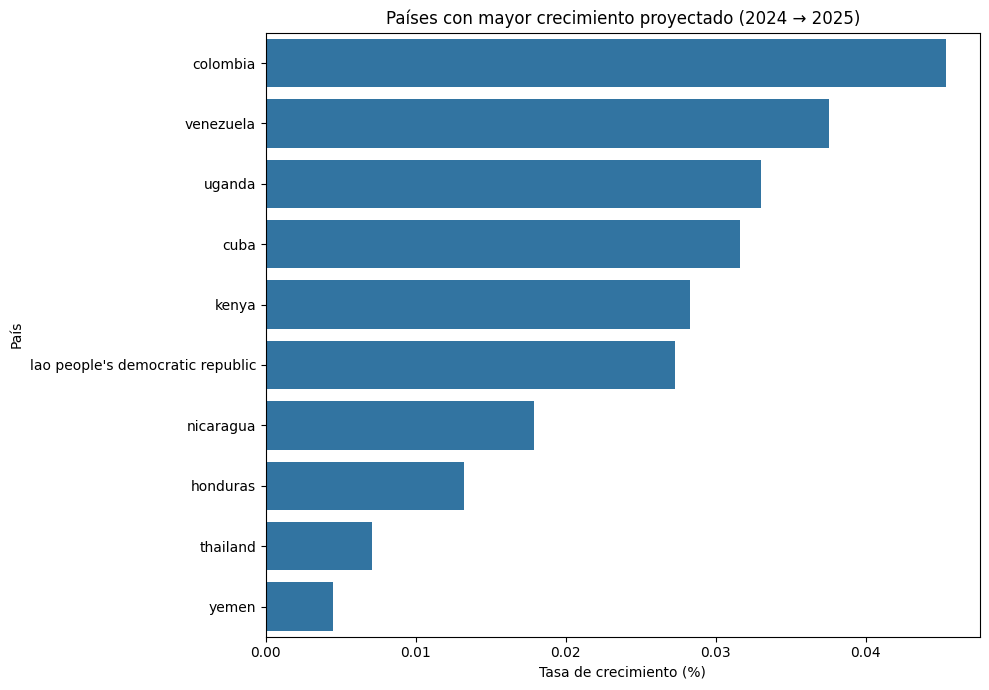


--- Top 10 Countries with Highest Predicted Growth (2024 -> 2025) ---
                             Country     pred_2024    pred_2025  pred_growth
54                          colombia  1.312398e+08  137189640.0     0.045335
1                          venezuela  8.019663e+07   83209379.4     0.037567
8                             uganda  1.402620e+07   14489100.0     0.033003
13                              cuba  1.306196e+07   13474560.0     0.031588
37                             kenya  4.359433e+06    4482643.2     0.028263
28  lao people's democratic republic  7.284900e+06    7483500.0     0.027262
51                         nicaragua  1.277174e+07   13000342.8     0.017899
43                          honduras  2.126300e+07   21544000.8     0.013215
46                          thailand  8.596560e+07   86573644.8     0.007073
53                             yemen  3.904939e+06    3922339.2     0.004456

Processed data saved to df_model.csv, future_2024.csv, future_2025.csv, growth_pr

KeyboardInterrupt: Interrupted by user

In [6]:
# --- 1. Install necessary libraries ---
# Update langchain-community and install langchain-huggingface for the new embedding import
!pip install pandas pyarrow
!pip install -U langchain langchain-community langchain-huggingface
!pip install faiss-cpu
!pip install httpx

# --- 2. Import Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# UPDATED: Import HuggingFaceEmbeddings from langchain_huggingface
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA

# Import necessary components for Cloudflare Workers AI integration
import httpx
import json
from langchain.llms.base import LLM
from typing import Optional, List, Mapping, Any
import os # For environment variables, though direct assignment is used below

# --- 3. Load Data ---
# IMPORTANT: Upload 'coffee_db.parquet' to your Google Colab session first.
# Click the folder icon on the left sidebar -> 'Upload to session storage' icon.
# Alternatively, if you have a public URL for your parquet file, uncomment and use the line below:
# !wget -O coffee_db.parquet "YOUR_PUBLIC_PARQUET_FILE_URL_HERE"

try:
    df = pd.read_parquet("coffee_db.parquet", engine="pyarrow")
    print("DataFrame loaded successfully:")
    print(df.head())
    print(f"DataFrame shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'coffee_db.parquet' not found.")
    print("Please upload the file to your Colab session or provide a public URL.")
    import sys
    sys.exit("Exiting: coffee_db.parquet not found.")

# --- 4. Data Preprocessing (as per your original code) ---
print("\n--- DataFrame Info ---")
print(df.info())
print("\n--- DataFrame Description ---")
print(df.describe())

df_long = df.melt(
    id_vars=["Country", "Coffee type", "Total_domestic_consumption"],
    var_name="year",
    value_name="consumption"
)
df_long["start_year"] = df_long["year"].str[:4].astype(int)

raw_end = df_long["year"].str[-2:].astype(int)
df_long["end_year"] = np.where(
    raw_end < 50,
    2000 + raw_end,
    1900 + raw_end
)

df_long.drop(columns="year", inplace=True)
print("\n--- df_long head (after initial melt and year processing) ---")
print(df_long.head(10))

df_long.columns = df_long.columns.str.strip().str.replace(" ", "_")
print("\n--- df_long head (after column cleanup) ---")
print(df_long.head())

print("\n--- Missing values ---")
print(df_long.isnull().sum())
missing = df_long[df_long["consumption"].isna()]
print("\nValores faltantes por país:")
print(missing.groupby("Country")["start_year"].count())

high_values = df_long[df_long["consumption"] > df_long["consumption"].mean() + 3 * df_long["consumption"].std()]
print("\nPosibles valores atípicos (consumption > mean + 3*std):")
print(high_values.sort_values("consumption", ascending=True))

percentil_95 = df_long["consumption"].quantile(0.95)
df_long["consumption_winsorized"] = df_long["consumption"].apply(lambda x: percentil_95 if x > percentil_95 else x)
df_long["consumption_winsorized"] = df_long["consumption_winsorized"].astype(int)
print("\n--- df_long head (with consumption_winsorized) ---")
print(df_long.head())

print("\n--- Data Types ---")
print(df_long.dtypes)
print(f"\nDuplicate rows: {df_long.duplicated().sum()}")

print("\nUnique Countries:", df_long['Country'].unique())
print("Unique Coffee Types:", df_long['Coffee_type'].unique())
print("Consumption Statistics:\n", df_long['consumption'].describe())

print("Rows with consumption <= 0:\n", df_long[df_long['consumption'] <=0])
print("Rows with consumption < 0:\n", df_long[df_long['consumption'] < 0])

df_long["Coffee_type"] = df_long["Coffee_type"].str.strip().str.lower()
df_long["Country"] = df_long["Country"].str.strip().str.lower()
print("\n--- df_long head (after country and coffee_type lowercasing) ---")
print(df_long.head())

# --- 5. Data Analysis and Visualization ---

# Analysis of highest total consumption per year
top_countries_vis = (
    df_long.groupby("Country")["consumption_winsorized"]
    .sum()
    .sort_values(ascending=False)
    .head(8)
    .index
)

df_top_vis = df_long[df_long["Country"].isin(top_countries_vis)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top_vis, x="start_year", y="consumption_winsorized", hue="Country")
plt.title("Consumo histórico de café - Top 8 países")
plt.xlabel("Año")
plt.ylabel("Consumo Winsorizado")
plt.legend(title="País")
plt.grid(True)
plt.show()

# Analysis of lowest total consumption per year
bottom_countries_vis = (
    df_long.groupby("Country")["consumption_winsorized"]
    .sum()
    .sort_values(ascending=True)
    .head(8)
    .index
)

df_bottom_vis = df_long[df_long["Country"].isin(bottom_countries_vis)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_bottom_vis, x="start_year", y="consumption_winsorized", hue="Country")
plt.title("Países con menor consumo de café")
plt.xlabel("Año")
plt.ylabel("Consumo Winsorizado")
plt.legend(title="País")
plt.grid(True)
plt.show()

# Year-over-year growth rate
df_long["growth"] = df_long.groupby("Country")["consumption_winsorized"].pct_change()

growth_avg = df_long.groupby("Country")["growth"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 7))
growth_avg.head(10).plot(kind="barh", title="Países con mayor crecimiento promedio")
plt.xlabel("Crecimiento Promedio")
plt.ylabel("País")
plt.tight_layout()
plt.show()

volatility = df_long.groupby("Country")["consumption_winsorized"].std().sort_values(ascending=False)
plt.figure(figsize=(10, 7))
volatility.head(10).plot(kind="barh", title="Países con mayor volatilidad de consumo")
plt.xlabel("Desviación Estándar del Consumo")
plt.ylabel("País")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long["Country"] == "madagascar"], x="start_year", y="consumption_winsorized")
plt.title("Consumo histórico de café en Madagascar")
plt.xlabel("Año")
plt.ylabel("Consumo Winsorizado")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long[df_long["Country"] == "tanzania"], x="start_year", y="consumption_winsorized")
plt.title("Consumo histórico de café en Tanzania")
plt.xlabel("Año")
plt.ylabel("Consumo Winsorizado")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
autocorrelation_plot(df_long[df_long["Country"] == "thailand"]["consumption_winsorized"])
plt.title("Autocorrelación del consumo de café en Tailandia")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
autocorrelation_plot(df_long[df_long["Country"] == "tanzania"]["consumption_winsorized"])
plt.title("Autocorrelación del consumo de café en Tanzania")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
autocorrelation_plot(df_long[df_long["Country"] == "rwanda"]["consumption_winsorized"])
plt.title("Autocorrelación del consumo de café en Ruanda")
plt.grid(True)
plt.show()

print("\n--- df_long head (after all processing) ---")
print(df_long.head())

# --- 6. Machine Learning Model (Random Forest Regressor) ---
df_long["lag_1"] = df_long.groupby("Country")["consumption_winsorized"].shift(1)
df_model = df_long.dropna(subset=["lag_1", "consumption_winsorized"])

X = df_model[["start_year", "Country", "Coffee_type", "lag_1"]]
y = df_model["consumption_winsorized"]

X_encoded = pd.get_dummies(X, columns=["Country", "Coffee_type"])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# --- 7. Future Predictions (2024 & 2025) ---
last_known = df_model.sort_values("start_year").groupby("Country").tail(1).copy()

future_2024 = last_known.copy()
future_2024["start_year"] = 2024
future_2024["lag_1"] = future_2024["consumption_winsorized"]

future_2025 = future_2024.copy()
future_2025["start_year"] = 2025

X_2024 = pd.get_dummies(future_2024[["start_year", "Country", "Coffee_type", "lag_1"]], columns=["Country", "Coffee_type"])
X_2024 = X_2024.reindex(columns=X_encoded.columns, fill_value=0)
future_2024["predicted"] = model.predict(X_2024)

future_2025["lag_1"] = future_2024["predicted"]
X_2025 = pd.get_dummies(future_2025[["start_year", "Country", "Coffee_type", "lag_1"]], columns=["Country", "Coffee_type"])
X_2025 = X_2025.reindex(columns=X_encoded.columns, fill_value=0)
future_2025["predicted"] = model.predict(X_2025)

growth_pred = pd.merge(
    future_2024[["Country", "predicted"]].rename(columns={"predicted": "pred_2024"}),
    future_2025[["Country", "predicted"]].rename(columns={"predicted": "pred_2025"}),
    on="Country"
)

growth_pred["pred_growth"] = (growth_pred["pred_2025"] - growth_pred["pred_2024"]) / growth_pred["pred_2024"]
growth_pred_sorted = growth_pred.sort_values("pred_growth", ascending=False).head(10)

plt.figure(figsize=(10, 7))
sns.barplot(data=growth_pred_sorted, x="pred_growth", y="Country")
plt.title("Países con mayor crecimiento proyectado (2024 → 2025)")
plt.xlabel("Tasa de crecimiento (%)")
plt.ylabel("País")
plt.tight_layout()
plt.show()

print("\n--- Top 10 Countries with Highest Predicted Growth (2024 -> 2025) ---")
print(growth_pred_sorted)

# --- 8. Save Processed Data to CSV (optional, for download/further use) ---
df_model.to_csv("df_model.csv", index=False)
future_2024.to_csv("future_2024.csv", index=False)
future_2025.to_csv("future_2025.csv", index=False)
growth_pred.to_csv("growth_pred.csv", index=False)
print("\nProcessed data saved to df_model.csv, future_2024.csv, future_2025.csv, growth_pred.csv")


# --- 9. Cloudflare Workers AI LLM Integration ---

# Custom LLM class for Cloudflare Workers AI
class CloudflareWorkersAILLM(LLM):
    """Custom LLM for Cloudflare Workers AI."""
    account_id: str
    api_token: str
    model_name: str = "@cf/meta/llama-2-7b-chat-int8" # Default model
    # Consider using a more capable model if available on your Cloudflare plan, e.g.:
    # model_name: str = "@cf/mistral/mistral-7b-instruct-v0.1" # Often performs better
    # model_name: str = "@cf/meta/llama-3.1-8b-instruct" # Larger context window available with Llama 3.1
    base_url: str = "https://api.cloudflare.com/client/v4/accounts"

    @property
    def _llm_type(self) -> str:
        return "cloudflare_workers_ai"

    def _call(self, prompt: str, stop: Optional[List[str]] = None, **kwargs: Any) -> str:
        headers = {
            "Authorization": f"Bearer {self.api_token}",
            "Content-Type": "application/json"
        }
        url = f"{self.base_url}/{self.account_id}/ai/run/{self.model_name}"
        data = {
            "messages": [{"role": "user", "content": prompt}]
        }

        try:
            response = httpx.post(url, headers=headers, json=data, timeout=120.0)
            response.raise_for_status()
            result = response.json()

            if "result" in result and "response" in result["result"]:
                return result["result"]["response"]
            elif "errors" in result:
                error_messages = "; ".join([e.get('message', 'Unknown error') for e in result['errors']])
                raise ValueError(f"Cloudflare Workers AI API error: {error_messages}")
            else:
                raise ValueError(f"Unexpected Cloudflare Workers AI API response: {json.dumps(result)}")
        except httpx.RequestError as exc:
            raise ValueError(f"An error occurred while requesting Cloudflare Workers AI: {exc}")
        except json.JSONDecodeError as exc:
            raise ValueError(f"Failed to decode JSON response from Cloudflare Workers AI: {exc}. Response text: {response.text}")
        except Exception as e:
            raise ValueError(f"An unexpected error occurred: {e}")

    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        return {
            "account_id": self.account_id,
            "model_name": self.model_name,
            "base_url": self.base_url
        }

# --- 10. Load Processed Data for LLM Context ---
# Re-load from CSVs saved above (or keep in memory if preferred and convenient)
df_model = pd.read_csv("df_model.csv")
future_2024 = pd.read_csv("future_2024.csv")
future_2025 = pd.read_csv("future_2025.csv")
growth_pred = pd.read_csv("growth_pred.csv")

docs = []

# --- 10.1. Add Individual Data Points as Documents ---
# Historical data
for _, row in df_model.iterrows():
    text = (
        f"En el año {int(row['start_year'])}, el país {row['Country']} con café tipo {row['Coffee_type']} "
        f"tuvo un consumo de {int(row['consumption_winsorized'])} unidades."
    )
    docs.append(Document(page_content=text))

# 2024 predictions
for _, row in future_2024.iterrows():
    text = (
        f"Predicción para 2024: el país {row['Country']} con café tipo {row['Coffee_type']} "
        f"tendrá un consumo proyectado de {int(row['predicted'])} unidades."
    )
    docs.append(Document(page_content=text))

# 2025 predictions
for _, row in future_2025.iterrows():
    text = (
        f"Predicción para 2025: el país {row['Country']} con café tipo {row['Coffee_type']} "
        f"tendrá un consumo proyectado de {int(row['predicted'])} unidades."
    )
    docs.append(Document(page_content=text))

# Growth predictions (2024-2025)
for _, row in growth_pred.iterrows():
    text = (
        f"Entre 2024 y 2025, el país {row['Country']} tendrá un crecimiento proyectado de "
        f"{round(row['pred_growth'] * 100, 2)}% en el consumo de café."
    )
    docs.append(Document(page_content=text))

# --- 10.2. Add Pre-Aggregated / Summary Documents for Better RAG ---

# Overall Top/Bottom Historical Consumers (based on total consumption)
total_consumption_by_country = df_long.groupby('Country')['consumption_winsorized'].sum().sort_values(ascending=False)

top_5_historical = total_consumption_by_country.head(5)
top_5_str = ", ".join([f"{country} ({value} unidades)" for country, value in top_5_historical.items()])
docs.append(Document(page_content=f"Los 5 países con el mayor consumo histórico total de café son: {top_5_str}."))

bottom_5_historical = total_consumption_by_country.tail(5)
bottom_5_str = ", ".join([f"{country} ({value} unidades)" for country, value in bottom_5_historical.items()])
docs.append(Document(page_content=f"Los 5 países con el menor consumo histórico total de café son: {bottom_5_str}."))

# Top 3 overall predicted growth
growth_pred_sorted_top3 = growth_pred.sort_values("pred_growth", ascending=False).head(3)
for _, row in growth_pred_sorted_top3.iterrows():
    docs.append(Document(page_content=f"El país con la mayor proyección de crecimiento en el consumo de café entre 2024 y 2025 es {row['Country']} con un crecimiento de {round(row['pred_growth'] * 100, 2)}%."))

# Coffee Type Summary
total_consumption_by_type = df_long.groupby('Coffee_type')['consumption_winsorized'].sum().sort_values(ascending=False)
for coffee_type, total_cons in total_consumption_by_type.items():
    docs.append(Document(page_content=f"El consumo total histórico del tipo de café {coffee_type} es de {int(total_cons)} unidades."))

# Top country for each coffee type (based on historical total consumption for that type)
for coffee_type in df_long['Coffee_type'].unique():
    subset = df_long[df_long['Coffee_type'] == coffee_type]
    if not subset.empty:
        top_country_for_type = subset.groupby('Country')['consumption_winsorized'].sum().idxmax()
        max_consumption_for_type = subset.groupby('Country')['consumption_winsorized'].sum().max()
        docs.append(Document(page_content=f"El país que históricamente más ha consumido café tipo {coffee_type} es {top_country_for_type} con un total de {int(max_consumption_for_type)} unidades."))


# --- 11. Initialize Embedding Model and Vectorstore ---
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(docs, embedding_model)

# --- 12. Configure Cloudflare Workers AI Credentials ---
cloudflare_account_id = "75d6bd4e5844feddcb01107cbb3c1488" # <<--- REPLACE THIS WITH YOUR ACCOUNT ID
cloudflare_api_token = "hbQF8DBDopnzFCaR4icBxc-qPfjMNBBllnuAHvWb"   # <<--- REPLACE THIS WITH YOUR API TOKEN

if "YOUR_CLOUDFLARE_ACCOUNT_ID" in cloudflare_account_id or "YOUR_CLOUDFLARE_API_TOKEN" in cloudflare_api_token:
    print("\n--- !!! WARNING !!! ---")
    print("Please replace 'YOUR_CLOUDFLARE_ACCOUNT_ID' and 'YOUR_CLOUDFLARE_API_TOKEN' with your actual Cloudflare credentials.")
    print("The chatbot will NOT function correctly without these. Exiting for user to update credentials.")
    import sys
    sys.exit("Exiting: Cloudflare credentials not set.")

# Initialize Cloudflare Workers AI LLM
llm = CloudflareWorkersAILLM(account_id=cloudflare_account_id, api_token=cloudflare_api_token)

# Setup RetrievalQA chain
# Increased 'k' to retrieve 10 most relevant documents.
# You can adjust 'k' based on your needs and LLM context window limits.
# Llama-2-7b-chat-int8 has a context window of 4096-8192 tokens.
# Mistral-7b-instruct-v0.1 has 8192 tokens (some versions up to 32k).
qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(search_kwargs={"k": 4}), # This line retrieves more docs
    return_source_documents=True
)

# --- 13. Chatbot Interaction Loop ---
print("\n🟢 Chatbot del consumo de café (con predicciones). Escribe 'salir' para terminar.\n")

while True:
    pregunta = input("👤 Tú: ")
    if pregunta.lower() in ["salir", "exit", "quit"]:
        print("👋 Hasta luego.")
        break

    try:
        result = qa.invoke({"query": pregunta})
        respuesta = result['result']
        source_documents = result['source_documents']

        print(f"🤖 Chatbot: {respuesta}\n")
        print("--- Documentos Fuente (Contexto para la respuesta) ---")
        if source_documents:
            for i, doc in enumerate(source_documents):
                print(f"  Documento {i+1}:\n    {doc.page_content}\n")
        else:
            print("  No se recuperaron documentos relevantes.")
        print("--------------------------------------------------\n")

    except Exception as e:
        print(f"❌ Error al comunicarse con el chatbot: {e}\n")
        print("Por favor, verifica tus credenciales de Cloudflare y la conexión a internet.")